In [1]:
!which python

/c/Users/bill_/scratch/ENV3/Scripts/python


In [197]:
!pip install h5py
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install astral
!pip install plotly
!pip install eumdac
!pip install requests
!pip install folium
!pip install cloudmesh-common
!pip install selenium
!pip install tqdm

In [198]:
import h5py
import numpy as np  
import matplotlib.pyplot as plt  
import os
import matplotlib.dates as mdates
import matplotlib.image as img 
from datetime import timedelta
import pandas as pd
from datetime import datetime
from astral.sun import sun
from astral import LocationInfo
import plotly.express as px

import eumdac
from IPython.core.display import HTML
import requests
import shutil
import time
from cloudmesh.common.util import readfile
from cloudmesh.common.util import path_expand
from cloudmesh.common.util import banner

import folium
import time
from selenium import webdriver
from tqdm import tqdm

In [199]:
import os

target = "gregor-mac"

if target == "os":
    BASE=os.environ["BASE"]
    DATA_DIR=os.environ["DATA_DIR"]
    PROJECT_SRC=os.environ["PROJECT_SRC"]
    PROJECT=os.environ["PROJECT"]
    ESAT=os.environ["ESAT"]
    EDITOR=os.environ["EDITOR"]
elif target == "rivanna":
    USER = os.environ["USER"]
    BASE=f"/scratch/{USER}"
    DATA_DIR="/nfs/flash/mlcommons/data"
    PROJECT_SRC=f"{BASE}/mlcommons/src"
    PROJECT=f"{PROJECT_SRC}/mlcommons"
    ESAT="~/.esat"
    EDITOR="emacs"
elif target == "ruoshen":
    BASE="C:/Users/bill_/scratch"
    DATA_DIR=f"{BASE}/mlcommons/data"
    PROJECT_SRC=f"{BASE}/mlcommons/src"
    PROJECT=f"{PROJECT_SRC}/mlcommons"
    ESAT="C:/Users/bill_/esat"
    EDITOR="???"
elif target == "gregor-linux":
    BASE="/scratch"
    DATA_DIR="/nfs/flash/mlcommons/data"
    PROJECT_SRC=f"{BASE}/mlcommons/src"
    PROJECT=f"{PROJECT_SRC}/mlcommons"
    ESAT="~/.esat"
    EDITOR="emacs"
elif target == "gregor-mac":
    BASE="/scratch"
    DATA_DIR="/Volumes/flash/mlcommons/data"
    PROJECT_SRC=f"{BASE}/mlcommons/src"
    PROJECT=f"{PROJECT_SRC}/mlcommons"
    ESAT="~/.esat"
    EDITOR="open -a aquamacs"

def get_var_name(var):
    """
    Get the name of a variable as a string.
    """
    for name, value in globals().items():
        if value is var:
            return name
    return None

def print_var(v, n=15):
    name = get_var_name(v)
    print(f"{name.ljust(n)}: {v}")

banner("ENVIRONMENT")
for v in [target,BASE,DATA_DIR,PROJECT_SRC,PROJECT,ESAT]:
    print_var(v)




# ----------------------------------------------------------------------
# ENVIRONMENT
# ----------------------------------------------------------------------

target         : gregor-mac
BASE           : /scratch
DATA_DIR       : /Volumes/flash/mlcommons/data
PROJECT_SRC    : /scratch/mlcommons/src
PROJECT        : /scratch/mlcommons/src/mlcommons
ESAT           : ~/.esat


# ---------------------------------------------------------------------------
# SET UP ESAT API KEY
# ---------------------------------------------------------------------------

To get the token please optein the API keys for consumer-key and secret-key by
executing the next line and copy them to the directory ~/.esat in the
appropriate files


In [200]:
for file_path in ["~/.esat/consumer-key", "~/.esat/consumer-secret"]:

    file_path = os.path.expanduser("~/.esat/consumer-key")

    # Check if the file exists
    if not os.path.exists(file_path):
        # Create an empty file if it doesn't exist
        with open(file_path, 'w') as file:
            pass
        print(f"Empty file created at: {file_path}")
    else:
        print(f"The file already exists at: {file_path}")

from cloudmesh.common.Shell import Shell
Shell.open("https://api.eumetsat.int/api-key/")

Shell.run(f"{EDITOR} ~/.esat/consumer-key")
Shell.run(f"{EDITOR} ~/.esat/consumer-secret")


The file already exists at: /Users/grey/.esat/consumer-key
The file already exists at: /Users/grey/.esat/consumer-key


''

In [201]:
import humanize

consumer_key = readfile(f"{ESAT}/consumer-key").strip()
consumer_secret = readfile(f"{ESAT}/consumer-secret").strip()

# print(consumer_key, consumer_secret)

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

try:
    print(f"This token '{token}' expires {token.expiration}")
    now = datetime.now()
    duration = token.expiration - now
    print(f"This is in {humanize.naturaltime(duration)}".replace("ago",""))
except requests.exceptions.HTTPError as exc:
    print(f"Error when tryng the request to the server: '{exc}'")

This token '73924a2e-171f-3361-a371-097a76d9811e' expires 2023-12-01 22:21:30.122927
This is in 14 minutes 


In [202]:
# Suggestion: rename the class to SLSTRFileAnalyzer
class SLSTRFileNameParser:
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_info = self.parse_file_name()

    def parse_file_name(self):
        components = [obj for obj in self.file_name.split('_') if obj!='']

        try:
            hdf = h5py.File(f"{DATA_DIR}/ssts/day/"+self.file_name, 'r')
            day = True
        except:
            hdf = h5py.File(f"{DATA_DIR}/ssts/night/"+self.file_name, 'r')
            day = False

        return {
            "filename": self.file_name,
            "mission_id": components[0],
            "data_source": components[1],
            "processing_level": components[2],
            "data_type_id": components[3],
            "start_time": datetime.strptime(components[4], "%Y%m%dT%H%M%S"),
            "stop_time": datetime.strptime(components[5], "%Y%m%dT%H%M%S"),
            "creation_date": datetime.strptime(components[6], "%Y%m%dT%H%M%S"),
            "instance_id": components[7]+'_'+components[8]+'_'+components[9]+'_'+components[10],
            "center_id": components[11],
            "class_id": components[12]+'_'+components[13]+'_'+components[14].split('.')[0],
            "file_extension": components[14].split('.')[1],
            "hdf_file": hdf,
            "daylight": "day" if day else "night"
        }

    def get_file_info(self):
        return self.file_info

    def hdf_info(self):
        file = self.hdf_file
        print(file.keys())
        for key in file.keys():
            dset = file[key]
            print(key, "-->", dset.dtype, dset.shape)

    @staticmethod
    def generate_dataframe(file_names):
        data = []
        for counter, file_name in enumerate(file_names, start=1):
            parser = SLSTRFileNameParser(file_name)
            file_info = parser.get_file_info()
            file_info['counter'] = counter
            data.append(file_info)

        return pd.DataFrame(data)

    # not used
    @staticmethod
    def plot_gantt_chart(dataframe):
        # Sort DataFrame by start time for correct Gantt chart representation
        df = dataframe.sort_values(by=['start_time'])

        # Create Gantt chart
        fig = px.timeline(df, 
                          x_start='start_time', 
                          x_end='stop_time', 
                          y='counter', 
                          color='processing_level',
                          labels={'counter':'counter', 
                                  'mission_id': 'Mission ID', 
                                  'start_time': 'Start Time', 
                                  'stop_time': 'Stop Time'},
                          title='SLSTR Products Gantt Chart',
                          )

        # Add counter as the first element in the labels
        fig.update_layout(xaxis_title='Time', 
                          yaxis_title='Counter', 
                          showlegend=False)
        fig.update_traces(text=df.apply(lambda row: f"{row['counter']} - {row.name}", axis=1), hoverinfo='text+y')

        # Show the chart
        fig.show()

    @staticmethod
    def plot_scatterplot(dataframe):
        # Sort DataFrame by start time for correct Gantt chart representation
        df = dataframe.sort_values(by=['start_time'])
    
        plt.figure(figsize=(16*5, 9*5))
        
        df.plot(kind='scatter', x='start_time', y='counter', label='Start Time', c='green', s=10)
        df.plot(kind='scatter', x='stop_time', y='counter', label='Stop Time', c='red', s=10, ax=plt.gca())
    
        plt.title('SLSTR Products Scatter Plot')
        plt.xlabel('Date & Time')
        plt.ylabel('Counter')
        plt.legend()
    
        # dtime = pd.date_range(start = '2019-10-01', end = '2019-10-31', freq = '10min')
        dtime = pd.date_range(start = df.iloc[0]['start_time'].strftime('%Y-%m-%d'), end = df.iloc[-1]['stop_time'].strftime('%Y-%m-%d'), freq = '10min')
    
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 3))
        plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval = 1))
        plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation = 45 )
        plt.gca().set_xlim(dtime[0], dtime[-1])
    
        plt.show()

    @staticmethod
    def plot_image_matrix(dataframe, sort_by_time=False, display_time_in_title=False):
        if sort_by_time:
            dataframe = dataframe.sort_values(by=['start_time'])
        
        fig, axs = plt.subplots(10, 10)
        for i in range(100):
            dset = dataframe.iloc[i]['hdf_file']['bayes']
            data = np.asarray(dset)
            row,col = divmod(i, 10)
            axs[row][col].imshow(data, cmap='gray')

            if display_time_in_title:
                time = dataframe.iloc[i]['start_time'].strftime('%Y-%m-%d')[-2:]
                # axs[row][col].title.set_text(time)
                # axs[row][col].title.set_color('red')
                # axs[row][col].title.set_position([0.5, 10.0])

                axs[row][col].text(0.5, 0.5, time, color='blue', fontsize=8)

            axs[row][col].axis('off')

        plt.show()
        # plt.savefig('inference_image_matrix.png', dpi=500)


    def is_daytime(self, latitude, longitude):
        # Extracting the date and time from the start_time in the file_info
        datetime_obj = self.file_info["start_time"]

        # Getting the location information
        location = LocationInfo(latitude, longitude)

        # Calculating the sunrise and sunset times for the given date and location
        s = sun(location.observer, date=datetime_obj)

        # Checking if the timestamp is between sunrise and sunset
        return s["sunrise"] < datetime_obj < s["sunset"]

# Example usage with multiple file names
# file_names = [
#     "S3A_SL_2_LST____20151229T095534_20151229T114422_20160102T150019_6528_064_365______LN2_D_NT_001.SEN3",
#     "S3B_SL_1_RBT_BW_20160101T120000_20160101T130000_20160101T140000_GLOBAL___________LN2_R_NT_002.SEN3",
#     # Add more file names as needed
# ]

# Creating a DataFrame using the class method
# df = SLSTRFileNameParser.generate_dataframe(file_names)

# Displaying the DataFrame
# print(df)

# Plotting Gantt chart using the class method
# SLSTRFileNameParser.plot_gantt_chart(df)

# Checking if timestamps are daytime using the class method
# latitude = 37.7749  # Replace with the latitude of the specific location
# longitude = -122.4194  # Replace with the longitude of the specific location

# Assuming you want to check daytime for the first file in the DataFrame
# print(f"{df.iloc[0]['filename']} is daytime: {SLSTRFileNameParser(df.iloc[0]['filename']).is_daytime(latitude, longitude)}")

In [203]:
data_path1 = f'{DATA_DIR}/ssts/day'
data_path2 = f'{DATA_DIR}/ssts/night'
temp = os.listdir(data_path1) + os.listdir(data_path2)

# print(data_path1)
# print(data_path2)
# print(temp)

In [204]:
# tmp_df1 = SLSTRFileNameParser.generate_dataframe(os.listdir(data_path1))
# tmp_df2 = SLSTRFileNameParser.generate_dataframe(os.listdir(data_path2))
# tmp_df1['daylight'] = 'day'
# tmp_df2['daylight'] = 'night'
# tmp_df2['counter'] += 55
# inference_df = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
inference_df = SLSTRFileNameParser.generate_dataframe(temp)
inference_df

,filename,mission_id,data_source,processing_level,data_type_id,start_time,stop_time,creation_date,instance_id,center_id,class_id,file_extension,hdf_file,daylight,counter
0,S3A_SL_1_RBT____20191001T113221_20191001T11352...,S3A,SL,1,RBT,2019-10-01 11:32:21,2019-10-01 11:35:21,2019-10-02 15:32:11,0179_050_023_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,1
1,S3A_SL_1_RBT____20191002T124409_20191002T12470...,S3A,SL,1,RBT,2019-10-02 12:44:09,2019-10-02 12:47:09,2019-10-03 18:06:38,0180_050_038_1800,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,2
2,S3A_SL_1_RBT____20191002T124709_20191002T12500...,S3A,SL,1,RBT,2019-10-02 12:47:09,2019-10-02 12:50:09,2019-10-03 18:08:06,0179_050_038_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,3
3,S3A_SL_1_RBT____20191002T125609_20191002T12590...,S3A,SL,1,RBT,2019-10-02 12:56:09,2019-10-02 12:59:09,2019-10-03 18:12:26,0179_050_038_2520,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,4
4,S3A_SL_1_RBT____20191003T122059_20191003T12235...,S3A,SL,1,RBT,2019-10-03 12:20:59,2019-10-03 12:23:59,2019-10-04 17:35:32,0179_050_052_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,S3A_SL_1_RBT____20191027T214628_20191027T21492...,S3A,SL,1,RBT,2019-10-27 21:46:28,2019-10-27 21:49:28,2019-10-29 01:32:17,0179_051_015_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,96
96,S3A_SL_1_RBT____20191029T003315_20191029T00361...,S3A,SL,1,RBT,2019-10-29 00:33:15,2019-10-29 00:36:15,2019-10-30 05:00:58,0179_051_031_0360,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,97
97,S3A_SL_1_RBT____20191029T223505_20191029T22380...,S3A,SL,1,RBT,2019-10-29 22:35:05,2019-10-29 22:38:05,2019-10-31 01:57:42,0179_051_044_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,98
98,S3A_SL_1_RBT____20191030T220854_20191030T22115...,S3A,SL,1,RBT,2019-10-30 22:08:54,2019-10-30 22:11:54,2019-11-01 02:57:13,0179_051_058_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,99


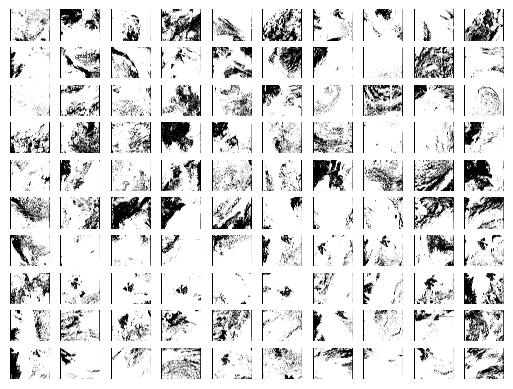

In [205]:
SLSTRFileNameParser.plot_image_matrix(inference_df)

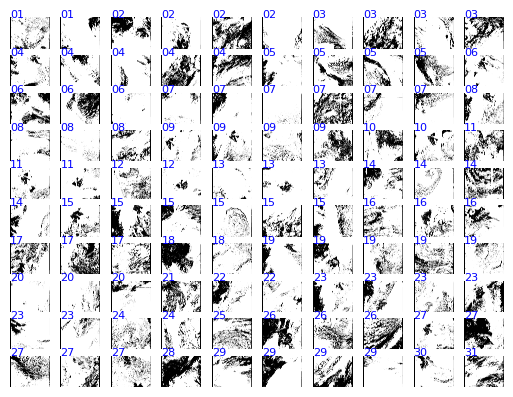

In [206]:
SLSTRFileNameParser.plot_image_matrix(inference_df, sort_by_time=True, display_time_in_title=True)

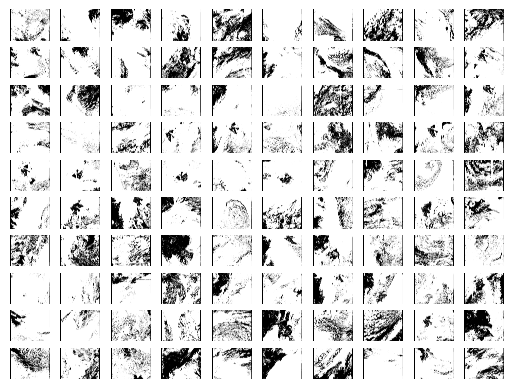

In [208]:
SLSTRFileNameParser.plot_image_matrix(inference_df, sort_by_time=True, display_time_in_title=False)

# Search & Download using EUMDAC API, from here below

In [209]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:0615')

In [210]:
def search_SENTINEL3_product(df_entry):
    start_time = df_entry['start_time'].replace(second=0).to_pydatetime()
    start_time = start_time + timedelta(seconds=60)
    stop_time = start_time
    sat_type = None
    
    print('start_time:', start_time)
    
    if df_entry['mission_id']=='S3A':
        sat_type = 'Sentinel-3A'  
    else:
        raise Exception("mission_id (sat_type) unexpected, should be S3A")
    
    products = selected_collection.search(
        dtstart=start_time,
        dtend=stop_time,
        sat=sat_type
    )
    
    if len(products)!=1:
        raise Exception("Error 1: Search finds multiple products.")
        
    selected_product = None
    for product in products:
        try:
            if str(product)[:47]==df_entry['filename'][:47]:
                selected_product = product
                print(product)
                print('Verification Successful.')
            else:
                raise Exception("Error 2: Verfication Failed.")
        except eumdac.collection.CollectionError as error:
            print(f"Error related to the collection: '{error.msg}'")
        except requests.exceptions.ConnectionError as error:
            print(f"Error related to the connection: '{error.msg}'")
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")

    return selected_product

In [211]:
# Download two files: browse.jpg (raw image), xfdumanifest.xml (contains longitude, latitude)
def download_additional_data(selected_product, path=f'{DATA_DIR}/ssts-additional-info/'):
    files = ['browse.jpg', str(selected_product)+'/xfdumanifest.xml']
    os.makedirs(path+str(selected_product))
    
    try:
        for file in files:
            with selected_product.open(entry=file) as fsrc, open(path+str(selected_product)+'/'+fsrc.name, mode='wb') as fdst:
                shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')
    except eumdac.product.ProductError as error:
        print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")
    except requests.exceptions.ConnectionError as error:
        print(f"Error related to the connection: '{error.msg}'")
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")

In [212]:
from tqdm import tqdm

dir_exist = False

try:
    os.makedirs(f'{DATA_DIR}/ssts-additional-info/')
except:
    print(f'{DATA_DIR}/ssts-additional-info/',"exists. Terminating downloads...")
    dir_exist = True
    
if not dir_exist:
    # for i in tqdm(range(len(inference_df)), desc="Downloading esat iamges"):
    for i in range(len(inference_df)):
        try:
            # Find all 100 inference satellite image products
            selected_product = search_SENTINEL3_product(inference_df.iloc[i])

            # Download additional files
            download_additional_data(selected_product, f'{DATA_DIR}/ssts-additional-info/')

            print(i, 'completed -------------------------------------------')
        except:
            raise Exception(f"Download is experiencing error at i={i}. Download is completed up to i={i-1}.")


    banner ('SUCCESS')

/Volumes/flash/mlcommons/data/ssts-additional-info/ exists. Terminating downloads...


# Extract Geo-Coordinates (Latitude, Longitude), from here below

In [213]:
additional_data_path = f'{DATA_DIR}/ssts-additional-info/'
new_file_list = [file[:47] for file in os.listdir(additional_data_path)]
# new_file_list

In [214]:
def update_dataframe_with_new_filename(dataframe, additional_data_path):
    df = dataframe.copy()
    new_file_list = [file for file in os.listdir(additional_data_path)]
    new_file_list_short = [file[:47] for file in os.listdir(additional_data_path)]
    df['new_filename'] = [None for i in range(len(df))]
    
    for i in range(len(df)):
        for j in range(len(new_file_list_short)):
            if df.iloc[i]['filename'][:47] == new_file_list_short[j]:
                df.loc[i, 'new_filename'] = new_file_list[j]

    return df

In [215]:
def extract_coordinates(dataframe, additional_data_path):
    df = dataframe.copy()
    df['min_latitude'] = [None for i in range(len(df))]
    df['max_latitude'] = [None for i in range(len(df))]
    df['min_longitude'] = [None for i in range(len(df))]
    df['max_longitude'] = [None for i in range(len(df))]

    for i in range(len(df)):
        with open(additional_data_path + df.iloc[i]['new_filename'] + '/xfdumanifest.xml', 'r') as f:
            data = f.read()
        long_str = data.strip().split('gml:posList')[1][1:-2]
        long_list = long_str.strip().split(' ')
        long_list = [float(coor) for coor in long_list]
        list1 = long_list[::2]
        list2 = long_list[1::2]
        
        df.loc[i, 'min_latitude'] = min(list1)
        df.loc[i, 'max_latitude'] = max(list1)
        df.loc[i, 'min_longitude'] = min(list2)
        df.loc[i, 'max_longitude'] = max(list2)
        
    return df

In [216]:
# thsi is wrong files must all be relative to esat and data_dir or . ? maybe ok if we document better

inference_df = update_dataframe_with_new_filename(inference_df, f'{DATA_DIR}/ssts-additional-info/')
inference_df = extract_coordinates(inference_df, f'{DATA_DIR}/ssts-additional-info/')
inference_df

,filename,mission_id,data_source,processing_level,data_type_id,start_time,stop_time,creation_date,instance_id,center_id,class_id,file_extension,hdf_file,daylight,counter,new_filename,min_latitude,max_latitude,min_longitude,max_longitude
0,S3A_SL_1_RBT____20191001T113221_20191001T11352...,S3A,SL,1,RBT,2019-10-01 11:32:21,2019-10-01 11:35:21,2019-10-02 15:32:11,0179_050_023_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,1,S3A_SL_1_RBT____20191001T113221_20191001T11352...,49.3736,62.9199,-27.3277,1.10981
1,S3A_SL_1_RBT____20191002T124409_20191002T12470...,S3A,SL,1,RBT,2019-10-02 12:44:09,2019-10-02 12:47:09,2019-10-03 18:06:38,0180_050_038_1800,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,2,S3A_SL_1_RBT____20191002T124409_20191002T12470...,59.3336,73.3693,-44.6162,-4.17663
2,S3A_SL_1_RBT____20191002T124709_20191002T12500...,S3A,SL,1,RBT,2019-10-02 12:47:09,2019-10-02 12:50:09,2019-10-03 18:08:06,0179_050_038_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,3,S3A_SL_1_RBT____20191002T124709_20191002T12500...,49.3902,62.9367,-46.0283,-17.5778
3,S3A_SL_1_RBT____20191002T125609_20191002T12590...,S3A,SL,1,RBT,2019-10-02 12:56:09,2019-10-02 12:59:09,2019-10-03 18:12:26,0179_050_038_2520,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,4,S3A_SL_1_RBT____20191002T125609_20191002T12590...,18.1641,31.4999,-51.0993,-34.0545
4,S3A_SL_1_RBT____20191003T122059_20191003T12235...,S3A,SL,1,RBT,2019-10-03 12:20:59,2019-10-03 12:23:59,2019-10-04 17:35:32,0179_050_052_1980,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",day,5,S3A_SL_1_RBT____20191003T122059_20191003T12235...,49.3862,62.9326,-39.4834,-11.0361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,S3A_SL_1_RBT____20191027T214628_20191027T21492...,S3A,SL,1,RBT,2019-10-27 21:46:28,2019-10-27 21:49:28,2019-10-29 01:32:17,0179_051_015_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,96,S3A_SL_1_RBT____20191027T214628_20191027T21492...,51.3203,64.9458,-23.332,6.80277
96,S3A_SL_1_RBT____20191029T003315_20191029T00361...,S3A,SL,1,RBT,2019-10-29 00:33:15,2019-10-29 00:36:15,2019-10-30 05:00:58,0179_051_031_0360,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,97,S3A_SL_1_RBT____20191029T003315_20191029T00361...,20.1914,33.5177,-49.4951,-32.1538
97,S3A_SL_1_RBT____20191029T223505_20191029T22380...,S3A,SL,1,RBT,2019-10-29 22:35:05,2019-10-29 22:38:05,2019-10-31 01:57:42,0179_051_044_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,98,S3A_SL_1_RBT____20191029T223505_20191029T22380...,51.3303,64.9386,-35.4784,-5.35265
98,S3A_SL_1_RBT____20191030T220854_20191030T22115...,S3A,SL,1,RBT,2019-10-30 22:08:54,2019-10-30 22:11:54,2019-11-01 02:57:13,0179_051_058_0900,LN2,O_NT_003,hdf,"[bayes, bts, rads, refs, summary]",night,99,S3A_SL_1_RBT____20191030T220854_20191030T22115...,51.3245,64.9323,-28.9257,1.19417


/var/folders/q5/s8_pcggn5f73xnz11zjqrhlw0000gp/T/ipykernel_49353/1219779378.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


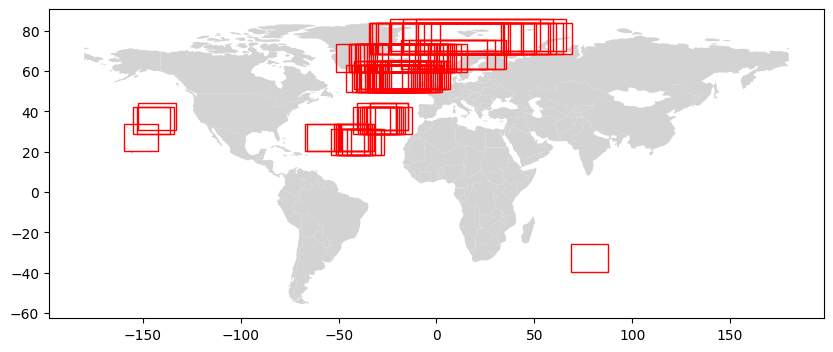

In [238]:
df = inference_df

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy((df.min_longitude + df.max_longitude) / 2, (df.min_latitude + df.max_latitude) / 2))


# Set the coordinate reference system (CRS)
# Note: The CRS should match the coordinate system of the latitude and longitude values
gdf.crs = "EPSG:4326"
# gdf.crs = "EPSG:3395" # Mercator
# gdf.crs = "EPSG:3857"


bounds = gdf.total_bounds

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot(figsize=(10, 5), color='lightgrey')
# gdf.plot(ax=ax, marker='o', color='red', markersize=50)

from matplotlib.patches import Rectangle

for index, row in gdf.iterrows():
    rect = Rectangle((row['min_longitude'], row['min_latitude']),
                     row['max_longitude'] - row['min_longitude'],
                     row['max_latitude'] - row['min_latitude'],
                     edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.show()

/var/folders/q5/s8_pcggn5f73xnz11zjqrhlw0000gp/T/ipykernel_49353/3125087745.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


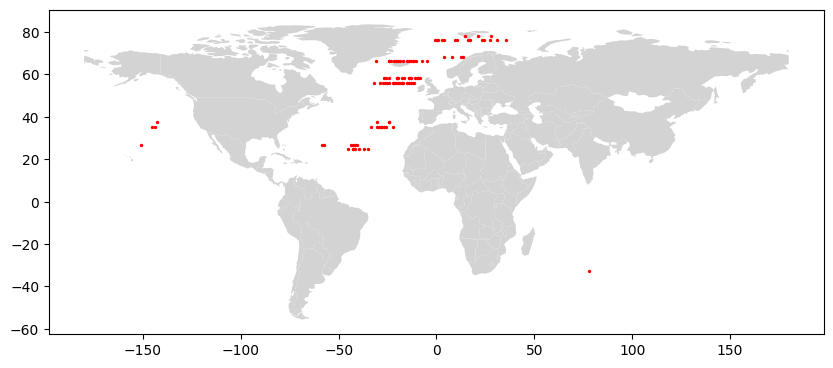

In [242]:
df = inference_df

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy((df.min_longitude + df.max_longitude) / 2, (df.min_latitude + df.max_latitude) / 2))


# Set the coordinate reference system (CRS)
# Note: The CRS should match the coordinate system of the latitude and longitude values
gdf.crs = "EPSG:4326"
# gdf.crs = "EPSG:3395" # Mercator
# gdf.crs = "EPSG:3857"


bounds = gdf.total_bounds

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot(figsize=(10, 5), color='lightgrey')
gdf.plot(ax=ax, marker='o', color='red', markersize=2)

plt.show()

In [233]:
def plot_image_matrix(dataframe, additional_data_path, image_name='/browse.jpg', sort_by_time=False, display_time_in_title=False):
    if sort_by_time:
        dataframe = dataframe.sort_values(by=['start_time'])
    
    fig, axs = plt.subplots(10, 10)
    for i in range(100):
        image = img.imread(additional_data_path + dataframe.iloc[i]['new_filename'] + image_name)
        row,col = divmod(i, 10)
        axs[row][col].imshow(image)

        if display_time_in_title:
            time = dataframe.iloc[i]['start_time'].strftime('%Y-%m-%d')[-2:]
            axs[row][col].title.set_text(time)
            
        axs[row][col].axis('off')

    # plt.show()
    plt.savefig('raw_inference_image_matrix.png', dpi=500)

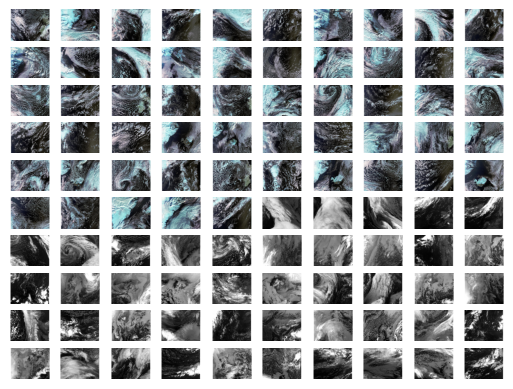

In [234]:
plot_image_matrix(inference_df, f'{DATA_DIR}/ssts-additional-info/')

In [186]:
# Define the delay for the browser to allow map tiles to load
delay = 5

# Set up a headless browser
options = webdriver.FirefoxOptions()
options.add_argument('--headless')

# Adjust the window size to make it effectively invisible
options.add_argument('window-size=800x600')

for i in tqdm(range(len(inference_df)), desc="Generating Maps"):
    latitude = [inference_df.iloc[i]['min_latitude'], inference_df.iloc[i]['max_latitude']]
    longitude = [inference_df.iloc[i]['min_longitude'], inference_df.iloc[i]['max_longitude']]

    m = folium.Map(location=(sum(latitude) / len(latitude), sum(longitude) / len(longitude)),
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)

    folium.Rectangle([(latitude[0], longitude[0]), (latitude[1], longitude[1])]).add_to(m)
    m.fit_bounds([[latitude[0], longitude[0]], [latitude[1], longitude[1]]])

    fn = 'testmap.html'
    tmpurl = 'file://{path}/{mapfile}'.format(path=os.getcwd(), mapfile=fn)
    m.save(fn)

    # Use the headless browser
    browser = webdriver.Firefox(options=options)
    browser.get(tmpurl)

    # Give the map tiles some time to load
    time.sleep(delay)

    # Save screenshot with a unique filename
    screenshot_filename = f'{DATA_DIR}/ssts-additional-info/{inference_df.iloc[i]["new_filename"]}/folium_map.png'
    browser.save_screenshot(screenshot_filename)

    browser.quit()

Generating Maps: 100%|██████████| 100/100 [12:59<00:00,  7.79s/it]


In [184]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

delay = 5

# Set up a headless browser
options = webdriver.FirefoxOptions()
options.add_argument('--headless')

# Adjust the window size to make it effectively invisible
options.add_argument('window-size=800x600')

def process_map(i):
    latitude = [inference_df.iloc[i]['min_latitude'], inference_df.iloc[i]['max_latitude']]
    longitude = [inference_df.iloc[i]['min_longitude'], inference_df.iloc[i]['max_longitude']]

    m = folium.Map(location=(sum(latitude) / len(latitude), sum(longitude) / len(longitude)),
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)

    folium.Rectangle([(latitude[0], longitude[0]), (latitude[1], longitude[1])]).add_to(m)
    m.fit_bounds([[latitude[0], longitude[0]], [latitude[1], longitude[1]]])

    fn = f'testmap-{i}.html'
    tmpurl = 'file://{path}/{mapfile}'.format(path=os.getcwd(), mapfile=fn)
    m.save(fn)

    # Use the headless browser
    browser = webdriver.Firefox(options=options)
    browser.get(tmpurl)

    # Give the map tiles some time to load
    time.sleep(delay)

    # Save screenshot with a unique filename
    screenshot_filename = f'{DATA_DIR}/ssts-additional-info/{inference_df.iloc[i]["new_filename"]}/folium_map.png'
    browser.save_screenshot(screenshot_filename)

    browser.quit()

# Number of parallel processes (adjust as needed)
num_cores = num_cores = multiprocessing.cpu_count() -1

with ThreadPoolExecutor(max_workers=num_cores) as executor:
    list(tqdm(executor.map(process_map, range(len(inference_df))), total=len(inference_df), desc="Generating Maps"))


Generating Maps:   0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

# Folium map generator, from here below

SyntaxError: not a PNG file (<string>)

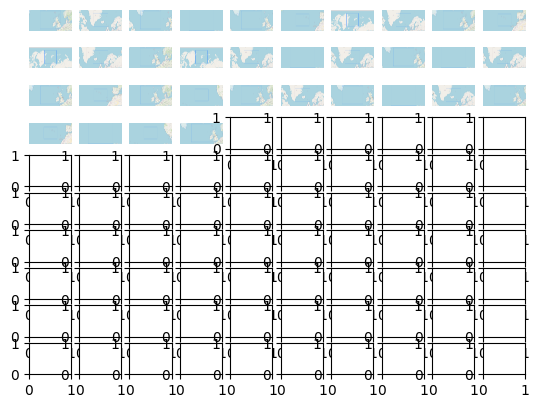

In [187]:
plot_image_matrix(inference_df, f'{DATA_DIR}/ssts-additional-info/', '/folium_map.png')

In [ ]:
# Define the delay for the browser to allow map tiles to load
delay = 5

# Set up a headless browser
options = webdriver.FirefoxOptions()
options.add_argument('--headless')

# Adjust the window size to make it effectively invisible
options.add_argument('window-size=800x600')

for i in tqdm(range(len(inference_df)), desc="Generating Maps"):
    latitude = [inference_df.iloc[i]['min_latitude'], inference_df.iloc[i]['max_latitude']]
    longitude = [inference_df.iloc[i]['min_longitude'], inference_df.iloc[i]['max_longitude']]

    m = folium.Map(location=(sum(latitude) / len(latitude), sum(longitude) / len(longitude)),
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)

    folium.Rectangle([(latitude[0], longitude[0]), (latitude[1], longitude[1])]).add_to(m)
    m.fit_bounds([[latitude[0], longitude[0]], [latitude[1], longitude[1]]])

    fn = 'testmap.html'
    tmpurl = 'file://{path}/{mapfile}'.format(path=os.getcwd(), mapfile=fn)
    m.save(fn)

    # Use the headless browser
    browser = webdriver.Firefox(options=options)
    browser.get(tmpurl)

    # Give the map tiles some time to load
    time.sleep(delay)

    # Save screenshot with a unique filename
    screenshot_filename = f'{DATA_DIR}/ssts-additional-info/{inference_df.iloc[i]["new_filename"]}/folium_map.png'
    browser.save_screenshot(screenshot_filename)

    browser.quit()

In [193]:

# Define the delay for the browser to allow map tiles to load

for i in tqdm(range(len(inference_gdf)), desc="Generating Maps"):
    row = inference_gdf.iloc[i]

    # Plot GeoDataFrame
    fig, ax = plt.subplots(figsize=(8, 6))
    inference_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal')

    # Save the figure with a unique filename
    os.system(f"mkdir -p {DATA_DIR}/ssts-additional-info/{row["new_filename"]}")
    fig_path = f'{DATA_DIR}/ssts-additional-info/{row["new_filename"]}/geopandas_map.png'
    plt.savefig(fig_path, bbox_inches='tight')

    plt.close()


Generating Maps: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]
